# 0. Description

Hi! I concieved of the ___Under the Hood___ series of Kaggle kernels as part of my machine learning training. The idea is to implement popular machine learning models in Python/Numpy and compare their performance against a benchmark, i.e. a similar model in the machine learning libraries like Scikit-learn or Keras. I agree with Andrej Karpathy who wrote in his [blog](http://karpathy.github.io/neuralnets/) : "...everything became much clearer when I started writing code." 

This kernel is dedicated to the ___Dense Neural Network___ (aka fully connected network) applied to the __MNIST__ dataset. We have the following __challenges__: 
for an adjustable network architecture implement model with He initialization, forward propagation with ReLU activation and dropout regularization in the hidden layers and Softmax activation in the output layer, cross-entropy cost function with L2 regularization, backpropagation and parameters update with stochastic gradient descent and Adam optimizer, and finally prediction of classificaton labels after learning the model for various hyperparameters. If compared to the __Titanic__ dataset, there are more features (pixels) in the input, and therefore we can try larger hidden layers size (512 in this kernel).
 
Any feedback or ideas are welcome.

In [1]:
# Load necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # data visualization
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # to convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. MNIST DATA

In [2]:
# Load datasets
train, test = pd.read_csv("../input/train.csv"), pd.read_csv("../input/test.csv")

In [3]:
# Review data
print(f'train data shape = {train.shape}', '/', f'test data shape = {test.shape}')
train.head()

train data shape = (42000, 785) / test data shape = (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# let's check the count of different labels in the dataset (~balanced)
train['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [5]:
# Numpy representation of the train and test data:
train_pixels, test_pixels = train.iloc[:,1:].values.astype('float32'), test.values.astype('float32') # all pixel values
train_labels = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits
train_labels = train_labels.reshape(-1, 1) # ensure proper shape of the array

print(f'train_pixels shape = {train_pixels.shape}')
print(f'test_pixels shape = {test_pixels.shape}')
print(f'train_labels shape = {train_labels.shape}')

train_pixels shape = (42000, 784)
test_pixels shape = (28000, 784)
train_labels shape = (42000, 1)


In [6]:
# Reshape input data to fit Keras model (height=28px, width=28px, channels=1):
train_pixels, test_pixels = train_pixels.reshape(-1, 28, 28, 1), test_pixels.reshape(-1, 28, 28, 1)
print(f'train_pixels shape = {train_pixels.shape}')
print(f'test_pixels shape = {test_pixels.shape}')

train_pixels shape = (42000, 28, 28, 1)
test_pixels shape = (28000, 28, 28, 1)


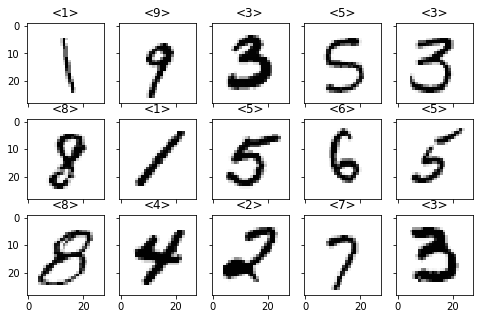

In [7]:
# Visualize some images from the dataset:
nrows, ncols = 3, 5  # number of rows and colums in subplots
fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(8,5))
for row in range(nrows):
    for col in range(ncols):
        i = np.random.randint(0, 30000)  # pick up arbitrary examples
        ax[row, col].imshow(train_pixels[i,:,:,0], cmap='Greys')
        ax[row, col].set_title(f'<{train.label[i]}>');

In [8]:
# Input data are greyscale pixels of intensity [0:255]. Let's normalize to [0:1]:
train_pixels, test_pixels = train_pixels / 255.0, test_pixels / 255.0

In [9]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
train_labels = to_categorical(train_labels, num_classes = 10)
print(f'train_labels shape = {train_labels.shape}')
train_labels

train_labels shape = (42000, 10)


array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [10]:
# Split training and validation set for the fitting
train_pixels, val_pixels, train_labels, val_labels = train_test_split(train_pixels, train_labels, test_size = 0.1, random_state=2)

train_pixels.shape, train_labels.shape, val_pixels.shape, val_labels.shape, test_pixels.shape

((37800, 28, 28, 1),
 (37800, 10),
 (4200, 28, 28, 1),
 (4200, 10),
 (28000, 28, 28, 1))

In [11]:
# let's fix the important numbers for further modeling:
m_train = train_pixels.shape[0]   # number of examples in the training set
m_val = val_pixels.shape[0]       # number of examples in the validation set
m_test = test_pixels.shape[0]     # number of examples in the test set
n_x = test.shape[1]               # input size, number of pixels in the image
n_y = train_labels.shape[1]       # output size, number of label classes
print(f" m_train = {m_train} / m_val = {m_val} / m_test = {m_test} / n_x = {n_x} / n_y = {n_y}")

 m_train = 37800 / m_val = 4200 / m_test = 28000 / n_x = 784 / n_y = 10


## 2. A DENSE NEURAL NETWORK IN KERAS

In [12]:
# Decide on the model architecture: [n_x, hidden_layers, n_y]
layer_dims = [n_x, 512, n_y]  # the model architecture is adjustable

In [20]:
# create an instance of a neural network:
k_model = Sequential()
# the first hidden layer must have input dimensions:
k_model.add(Flatten(input_shape=[28,28,1]))
k_model.add(Dense(layer_dims[1], activation='relu',
                  kernel_regularizer=l2(0)))
k_model.add(Dropout(0.25))
# additional hidden layers are optional
# output layer w/softmax activation:
k_model.add(Dense(n_y, activation='softmax',
                  kernel_regularizer=l2(0)))

# Compile the model w/Adam optimizer:
k_model.compile(optimizer=Adam(lr=1e-2),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-6)
# Train the model:
k_model.fit(train_pixels, train_labels, epochs=30, batch_size=128,
            callbacks=[lr_decay], verbose=0)

# Evaluate the model:
k_train_loss, k_train_acc = k_model.evaluate(train_pixels, train_labels)
k_val_loss, k_val_acc = k_model.evaluate(val_pixels, val_labels)

print(f'k_model: train accuracy = {round(k_train_acc * 100, 4)}%')
print(f'k_model: val accuracy = {round(k_val_acc * 100, 4)}%')
print(f'k_model: val error = {round((1 - k_val_acc) * m_val)} examples')


4200/4200 [==============================] - 0s 62us/step
k_model: train accuracy = 99.9894%
k_model: val accuracy = 98.1905%
k_model: val error = 76.0 examples


## 3. A CUSTOM NEURAL NETWORK IN PYTHON/NUMPY (classification)

Let's have a look "under the hood" at a similar model in Python/Numpy and appreciate the greatness of Keras :)

### 3.1 Reshape data and define mini-batches

In [14]:
# Reshape data to fit the Custom Model architecture: (n_pixels, m_examples)
X_train = train_pixels.reshape(m_train, -1).T
Y_train = train_labels.T
X_val   = val_pixels.reshape(m_val,-1).T
Y_val   = val_labels.T
X_test  = test_pixels.reshape(m_test, -1).T

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape

((784, 37800), (10, 37800), (784, 4200), (10, 4200), (784, 28000))

In [15]:
# Define a function to create random mini-batches for the gradient descent:
def random_mini_batches(X, Y, batch_size):
    """
    This funcion creates a list of random minibatches from (X, Y)
    Arguments:
        X -- input data, of shape (input size, number of examples)
        Y -- "true" labels vector, of shape (output size, number of examples)
        batch_size -- size of mini-batches, integer
    Returns:
        mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    m = X.shape[1]              # number of examples
    mini_batches = []           # initialize a list to contain all minibatches
        
    # Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    # Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = m // batch_size # number of minibatches of size batch_size
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*batch_size:(k+1)*batch_size]
        mini_batch_Y = shuffled_Y[:, k*batch_size:(k+1)*batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m_train % batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### 3.2 Define a neural network model with fully connected layers

In [16]:
class Custom_model(object):
    
    def __init__(self, layer_dims):
        """ 
        The model consists of the input layer (pixels), a number of hidden layers and
        the output layer (categorical classifier). To create an instance of the model, we set
        dimensions of its layers and initialize parameters for the hidden/ output layers.
        Arguments: 
            layer_dims -- list containing the input size and each layer size
        Returns: 
            parameters -- python dictionary containing parameters "W1", "b1", ..., "WL", "bL":
                Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                bl -- bias vector of shape (layer_dims[l], 1) 
        """
        self.layer_dims = layer_dims       # a list with dimensions of all layers
        self.num_layers = len(layer_dims)  # number of layers (with input layer)
        self.parameters = {}        # a dictionary with weights and biases of the model
        # Initializing weights randomly (He initialization) and biases to zeros
        for l in range(1, len(layer_dims)):
            self.parameters[f"W{l}"] = np.random.randn(layer_dims[l], 
                                                       layer_dims[l-1])*np.sqrt(2./layer_dims[l-1])
            self.parameters[f"b{l}"] = np.zeros((layer_dims[l], 1))
    
    # define getters and setters for accessing the model class attributes:        
    def get_layer_dims(self):
        return self.layer_dims
    def get_num_layers(self):
        return self.num_layers
    def get_params(self, key):
        return self.parameters.get(key)
    def set_params(self, key, value):
        self.parameters[key] = value
    
        
    def forward_propagation(self, X, keep_prob):
        """ 
        Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SOFTMAX computation
        Arguments:
            X -- data, numpy array of shape (input size, number of examples)
            keep_prob - probability of keeping a neuron active during drop-out, scalar
        Returns:
            AL -- last post-activation value
            caches -- list of caches containing:
               every cache of layers w/ReLU activation (there are L-1 of them, indexed from 0 to L-2)
               the cache of the output layer with Softmax activation (there is one, indexed L-1)
        """
        caches = []
        L = self.get_num_layers()-1    # number of layers with weights (hidden + output)
        A = X                          # set input as the first hidden layer activation
        # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
        for l in range(1, L):
            A_prev = A                # initialize activation of the previous layer
            W, b = self.get_params(f'W{l}'), self.get_params(f'b{l}') # get weights and biases
            Z = W.dot(A_prev) + b     # linear activation for the hidden layers
            A = np.maximum(0,Z)       # ReLU activation for the hidden layers
            if keep_prob == 1:        # if no dropout
                cache = (A_prev, Z)   # useful during backpropagation
            elif keep_prob < 1:       # if dropout is used for regularization
                D = np.random.rand(A.shape[0], A.shape[1])  # initialize matrix D
                D = D < keep_prob   # convert entries of D to 0/1 (using keep_prob as threshold)
                A *= D              # shut down some neurons of A
                A /= keep_prob      # scale the value of neurons that haven't been shutdown
                cache = (A_prev, Z, D)   # useful during backpropagation
            caches.append(cache)
        # Implement LINEAR -> SOFTMAX. Add "cache" to the "caches" list.
        W, b = self.get_params(f'W{L}'), self.get_params(f'b{L}')
        Z = W.dot(A) + b                        # Linear activation of the output layer
        Z -= np.max(Z, axis=0, keepdims=True)   # Normalize Z to make Softmax stable
        AL = np.exp(Z)/np.sum(np.exp(Z),axis=0,
                              keepdims=True) # Softmax activation of the output layer
        cache = (A, Z)                          # useful during backpropagation
        caches.append(cache)
        return AL, caches
        
    
    def compute_cost(self, AL, Y, lambd):
        """
        Implement the cost function with L2 regularization.
        Arguments:
            AL -- post-activation, output of forward propagation,
                                    of shape (output size, number of examples)
            Y -- "true" labels vector, of shape (output size, number of examples)
            lambd -- regularization hyperparameter, scalar
        Returns:
            cost - value of the regularized loss function
        """
        m = AL.shape[1]               # number of training examples
        L = self.get_num_layers()-1   # number of layers with weights (hidden and output)
        assert(Y.shape == AL.shape)
        # Compute the cross-entropy part of the cost for Softmax activation function:
        cross_entropy_cost = -(1./m) * np.sum(np.multiply(Y, np.log(AL)))

        # Compute L2 regularization cost
        L2_reg_cost = 0
        if lambd == 0:
            pass
        else:
            for l in range(1, L+1):     # sum of all squared weights
                L2_reg_cost += (1./m)*(lambd/2)*(np.sum(np.square(self.get_params(f'W{l}'))))

        # Total cost:
        cost = cross_entropy_cost + L2_reg_cost
        # To make sure cost's shape is what we expect (e.g. this turns [[17]] into 17).
        cost = np.squeeze(cost)   
        return cost
    
            
    def backward_propagation(self, AL, Y, caches, lambd, keep_prob):
        """ 
        Implement the backward propagation for the [LINEAR->RELU]*(L-1)->[LINEAR->SOFTMAX]
        Arguments:
            AL -- probability vectors for the training examples, output of the forward propagation
            Y -- true one-hot "label" vectors for the training examples
            caches -- list of caches containing:
                every cache of forward propagation with "relu" 
                                        (there are (L-1) or them, indexes from 0 to L-2)
                the cache of forward propagation with "softmax" (there is one, index L-1)
            lambd -- lambda, an L2 regularization parameter, scalar
            keep_prob - probability of keeping a neuron active during drop-out, scalar
        Returns: grads -- a dictionary with updated gradients
        """
        L = self.get_num_layers()-1  # number of layers with weights (hidden and output)
        m = AL.shape[1]              # number of training examples
        assert(Y.shape == AL.shape)
        grads = {}                   # a dict for the gradients of the cost function

        # Lth layer (SOFTMAX -> LINEAR) gradients.
        W = self.get_params(f"W{L}") # get weights for the output layer
        if keep_prob == 1:           # without dropout
            A_prev, Z = caches[L-1]  # get inputs and linear activations for the output layer
        elif keep_prob < 1:          # with dropout 
            A_prev, Z, D = caches[L-1]  # get inputs, linear activations and mask
        dZ = AL - Y                  # Gradient of the cost w.r.t. Z (from calculus)
        dW = (1./m) * dZ.dot(A_prev.T) + (lambd/m) * W  # Gradient of cost w.r.t. W
        db = (1./m) * np.sum(dZ, axis=1, keepdims=True) # Gradient of cost w.r.t. b
        dA_prev = np.dot(W.T,dZ)                        # Gradient of cost w.r.t. dA_prev
        if keep_prob == 1:           # without dropout
            pass
        elif keep_prob < 1:          # with dropout
            dA_prev *= D   # apply mask D to shutdown the same neurons as during forward prop
            dA_prev /= keep_prob  # scale the value of neurons that haven't been shut down
        # Update the grads dictionary for the output layer
        grads[f"dA{L-1}"] = dA_prev
        grads[f"dW{L}"], grads[f"db{L}"] = dW, db

        # l-th hidden layer: (RELU -> LINEAR) gradients.
        for l in reversed(range(1, L)):
            W = self.get_params(f"W{l}") # get weights for the l-th hidden layer
            if keep_prob == 1:           # without dropout
                A_prev, Z = caches[l-1]  # get ReLU & linear activations for l-th hidden layer
            elif keep_prob < 1:          # with dropout
                A_prev, Z, D = caches[l-1]    # get ReLU & linear activations + mask
            dZ = np.array(dA_prev, copy=True) # just converting dz to a correct object.
            dZ[Z <= 0] = 0                    # when z <= 0, set dz to 0 as well. 
            dW = (1./m) * dZ.dot(A_prev.T) + (lambd/m) * W  # Gradient of cost w.r.t. W
            db = (1./m) * np.sum(dZ, axis=1, keepdims=True) # Gradient of cost w.r.t. b
            dA_prev = np.dot(W.T,dZ)          # Gradient of cost w.r.t. dA_prev
            if keep_prob == 1:                # without dropout
                pass
            elif keep_prob < 1:               # with dropout
                dA_prev *= D  # apply mask to shutdown the same neurons as during forward prop
                dA_prev /= keep_prob # scale the value of neurons that haven't been shut down
            # Update the grads dictionary for the hidden layers
            grads[f"dA{l-1}"] = dA_prev 
            grads[f"dW{l}"], grads[f"db{l}"] = dW, db
        
        return grads
    
        
    def update_parameters_with_gd(self, grads, lr):
        """ 
        Update parameters of the model using method gradient descent
        Arguments:
            grads -- python dictionary containing gradients, output of backprop
            lr -- the learning rate, scalar
        Returns: 
            updated parameters (weithts and biases of the model)
        """
        L = self.get_num_layers()-1  # get number of layers with weights (hidden + output)
        for l in range(1, L+1):
            self.set_params(f"W{l}", self.get_params(f"W{l}") - lr * grads[f"dW{l}"])
            self.set_params(f"b{l}", self.get_params(f"b{l}") - lr * grads[f"db{l}"])
               
            
    def initialize_adam(self):
        """
        Initializes v and s for the Adam optimizer as two python dictionaries with:
            keys: "dW1", "db1", ..., "dWL", "dbL" 
            values: numpy arrays of zeros of the same shape as the corresponding gradients.
        Returns: 
            v -- python dict that will contain the exponentially weighted average of the gradient.
            s -- python dict that will contain the exponentially weighted average of the squared gradient.
        """
        v = {}   
        s = {}
        L = self.get_num_layers()-1   # get number of layers with weights (hidden and output)
        for l in range(1, L+1):
            v[f"dW{l}"] = np.zeros((self.get_params(f"W{l}").shape))
            v[f"db{l}"] = np.zeros((self.get_params(f"b{l}").shape))
            s[f"dW{l}"] = np.zeros((self.get_params(f"W{l}").shape))
            s[f"db{l}"] = np.zeros((self.get_params(f"b{l}").shape))    
        return v,s
    
    
    def update_parameters_with_adam(self, grads, v, s, t, lr, beta1, beta2, epsilon):
        """
        Update parameters of the model using Adam optimization algorithm
        Arguments:
            v -- Adam variable, moving average of the first gradient, python dict
            s -- Adam variable, moving average of the squared gradient, python dict
            t -- current timestep (minibatch)
            lr -- the learning rate, scalar.
            beta1 -- Exponential decay hyperparameter for the first moment estimates 
            beta2 -- Exponential decay hyperparameter for the second moment estimates 
            epsilon -- hyperparameter preventing division by zero in Adam updates
        Returns:
            updated parameters (model attributes)
            v -- Adam variable, moving average of the first gradient, python dict
            s -- Adam variable, moving average of the squared gradient, python dict
        """
        v_corr = {}       # Initializing a bias-corrected first moment
        s_corr = {}       # Initializing a bias corrected second moment estimate
        L = self.get_num_layers()-1   # get number of layers with weights (hidden+output)
        
        # Perform Adam update on all parameters
        for l in range(1, L+1):
            # Moving average of the gradients
            v[f"dW{l}"] = beta1*v[f"dW{l}"] + (1-beta1)*grads[f"dW{l}"]
            v[f"db{l}"] = beta1*v[f"db{l}"] + (1-beta1)*grads[f"db{l}"]

            # Compute bias-corrected first moment estimate
            v_corr[f"dW{l}"] = v[f"dW{l}"]/(1-beta1**t)
            v_corr[f"db{l}"] = v[f"db{l}"]/(1-beta1**t)

            # Moving average of the squared gradients
            s[f"dW{l}"] = beta2*s[f"dW{l}"] + (1-beta2)*grads[f"dW{l}"]**2
            s[f"db{l}"] = beta2*s[f"db{l}"] + (1-beta2)*grads[f"db{l}"]**2

            # Compute bias-corrected second raw moment estimate
            s_corr[f"dW{l}"] = s[f"dW{l}"]/(1-beta2**t)
            s_corr[f"db{l}"] = s[f"db{l}"]/(1-beta2**t)

            # Update parameters
            temp_W = v_corr[f"dW{l}"]/(s_corr[f"dW{l}"]**0.5 + epsilon)
            temp_b = v_corr[f"db{l}"]/(s_corr[f"db{l}"]**0.5 + epsilon)
            self.set_params(f"W{l}", self.get_params(f"W{l}") - lr*temp_W)
            self.set_params(f"b{l}", self.get_params(f"b{l}") - lr*temp_b)

        return v, s
        
        
    def predict(self, X):
        """ 
        This method is used to predict the results of a L-layer neural network.
        Arguments:
            X -- dataset of examples to label, shape (num_pixels, num_examples)
        Returns:
            p -- predictions of one-hot labels for X, shape (num_classes, num_examples)
        """
        m = X.shape[1]          # number of examples
        # Forward propagation
        AL, _ = self.forward_propagation(X, keep_prob=1)
        n = AL.shape[0]         # number of classes
        p = np.zeros((n, m))    # initialize predictions
        # convert probabilities AL to one-hot label predictions:
        for i in range(m):
            max_i = np.amax(AL[:,i], axis=0)
            for j in range(n):
                if AL[j,i] == max_i:
                    p[j,i] = 1
                else:
                    p[j,i] = 0
        return np.int64(p)
    
        
    def fit(self, X, Y, batch_size, num_epochs, lr, min_lr=1e-6, lambd=0, keep_prob=1,
            beta1=0.9, beta2=0.999, epsilon=1e-8, optimizer='adam', print_cost=False):
        """ 
        Implements an L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SOFTMAX.
        Arguments:
            X -- data, numpy array of shape (# pixels, # examples)
            Y -- true "label" vector, of shape (# classes, # examples)
            batch_size -- the size of a mini batch on which parameters are get updated
            num_epochs -- number of epochs, i.e. passes through the training set
            lr -- learning rate of the gradient descent update rule
            min_lr -- the lower threshold of the learning rate decay
            lambd -- lambda, the L2 regularization hyperparameter
            optimizer -- optimization metod ["gd"=gradient_descent or "adam"]
            beta1 -- exp decay hyperparameter for the past gradients estimates in 'adam'
            beta2 -- exp decay hyperparameter for the past squared gradients estimates in 'adam'
            epsilon -- hyperparameter preventing division by zero in 'adam' updates
            print_cost -- if True, it prints the cost every # steps
        Returns:
            parameters -- parameters learnt by the model. They can then be used to predict.
        """
        costs = []                # to keep track of the cost
        lr_0 = lr                 # to fix the initial learning rate before decay
        t = 0                     # initializing the minibatch counter (for Adam update)
        cost_prev = 1000          # initialize cost to a big number
        # Initialize the optimizer
        if optimizer == "gd":
            pass                  # no initialization required for gradient descent
        elif optimizer == "adam":
            v, s = self.initialize_adam()
        # Optimization loop
        for epoch in range(num_epochs):
            # Define the random minibatches. Reshuffle the dataset after each epoch
            minibatches = random_mini_batches(X, Y, batch_size)
            for minibatch in minibatches:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # Forward propagation: [LINEAR->RELU]*(L-1) -> LINEAR->SOFTMAX.
                AL, caches = self.forward_propagation(minibatch_X, keep_prob)
                # Compute cost.
                cost = self.compute_cost(AL, minibatch_Y, lambd)
                # Backward propagation.
                grads = self.backward_propagation(AL, minibatch_Y, caches, lambd, keep_prob)
                # Update parameters
                t = t + 1 # minibatch counter
                if optimizer == "gd":
                    self.update_parameters_with_gd(grads, lr)
                elif optimizer == "adam":
                    v, s = self.update_parameters_with_adam(grads, v, s, t, lr, 
                                                            beta1, beta2, epsilon)
                # Define learning rate decay:
                if cost > cost_prev and lr > min_lr:
                    lr = lr / 2   # reduce lr, but not below the min value
                cost_prev = cost  # save cost value for the next iteration
                
            # Print the cost every 20 epoch
            if print_cost and epoch % 20 == 0:
                print(f"Cost after epoch {epoch}: {cost}")
            if print_cost and epoch % 1 == 0:    
                costs.append(cost)
        # plot the Learning curve
        if print_cost:
            plt.plot(np.squeeze(costs))
            plt.ylabel("cost")
            plt.xlabel("epochs (x 1)")
            plt.title(f"Learning rate = {lr_0} / {lr}")
            plt.show()

### **4. MODEL TRAINING  **

In [17]:
# Create list to save journal records of the current session
records_list = []

Cost after epoch 0: 2.3387291205305765
Cost after epoch 20: 0.3984680863255955
Cost after epoch 40: 0.26603308181857244
Cost after epoch 60: 0.20921134167049113
Cost after epoch 80: 0.17118254075006814
Cost after epoch 100: 0.1419138958988666
Cost after epoch 120: 0.1186052346055381
Cost after epoch 140: 0.09977415854553706
Cost after epoch 160: 0.08436915694386227
Cost after epoch 180: 0.07158805673583453


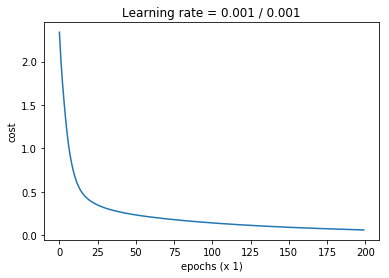

c_model: train accuracy: 99.0%
c_model: val accuracy = 97.0%
c_model: val error = 126.0 examples


,acc_train,acc_val,batch_size,keep_prob,lambda,layer_dims,learning_rate,lr,min_lr,num_epochs,val_error
0,1.00,0.97,37800,NaN,0.0,"[784, 512, 10]",0.001,NaN,1.000000e-08,300,126.0
1,0.98,0.96,37800,0.75,0.0,"[784, 512, 10]",NaN,0.001,1.000000e-08,200,168.0
2,0.99,0.97,37800,0.50,0.0,"[784, 512, 10]",NaN,0.001,1.000000e-08,200,126.0


In [22]:
# Create an instance of the Custom_model class with 'layer_dims' architecture:
c_model = Custom_model(layer_dims)

# Set hyperparameters that we want to tune for the custom model:
lr          = 1e-3    # the learning rate for the gradient descent
min_lr      = 1e-8    # the lower threshold of the learning rate decay
optimizer   = 'adam'
batch_size  = m_train  
num_epochs  = 300          
lambd       = 0       # lambda - regularization hyperparameter, scalar
keep_prob   = 0.5    # keep_prob - probability of keeping a neuron active during dropout

# Train the model at various hyperparameters settings:
c_model.fit(X_train, Y_train, batch_size=batch_size, num_epochs=num_epochs,
            lr=lr, min_lr=min_lr, lambd=lambd, optimizer=optimizer,
            print_cost=True)       

# Evaluation on the train data:
predict_train = c_model.predict(X_train)
correct_train = np.argmax(predict_train, axis=0) == np.argmax(Y_train, axis=0)
c_train_acc = round(np.sum(correct_train)/m_train, 2)

# Evaluation on the validation data:
predict_val = c_model.predict(X_val)
correct_val = np.argmax(predict_val, axis=0) == np.argmax(Y_val, axis=0)
c_val_acc = round(np.sum(correct_val)/m_val, 2)

print(f"c_model: train accuracy: {c_train_acc * 100}%")
print(f"c_model: val accuracy = {c_val_acc * 100}%")
print(f'c_model: val error = {round((1 - c_val_acc) * m_val)} examples')

# Update the journal of hyperparameters tuning records
record = {'layer_dims'   : c_model.get_layer_dims(), 
          'acc_train'    : c_train_acc, 
          'acc_val'      : c_val_acc,
          'val_error'    : round((1 - c_val_acc) * m_val),
          'batch_size'   : batch_size,
          'num_epochs'   : num_epochs,
          'lr'           : lr,
          'min_lr'       : min_lr,
          'lambda'       : lambd,
          'keep_prob'    : keep_prob}

records_list.append(record)
journal = pd.DataFrame(records_list)   # saves records when repeatedly running the current cell
journal

## Conclusion: we have looked "under the hood" of a fully connected network with ReLU activation and dropout regularization for the hidden layers, Softmax activation for the output layer, cross-entropy cost with L2 regularization, and parameters update with Adam optimization. 

## Great! We know how it works!

# -1. Submitting Predictions to Kaggle

In [19]:
# Predict labels on the test dataset with the Custom model:
predict_test = c_model.predict(X_test)   # one-hot prediction vectors
predictions = np.argmax(predict_test, axis=0)  # label predictions

submission = pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                           "Label"  : predictions})
submission.to_csv("submission.csv", index=False, header=True)
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
